In [1]:
path_ = r'C:\Users\Itay\Documents\ipcaLocal\Centroid Figures for Jialin Paper'

In [2]:
import mpl_toolkits.mplot3d as a3
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy import interpolate
import scipy.linalg as sp
import math
import os
import glob 
import torch as th
from random import choices
import tqdm
import pickle
# save path 
save_path = path_
num_chkpoints = 2043

t_jialin = np.array([    0,     1,    63,   125,   187,   249,   251,   313,   375,
      437,   499,   501,   563,   625,   687,   749,   751,   813,
      875,   937,   999,  1001,  1063,  1125,  1187,  1249,  1500,
     1750,  2000,  2250,  2500,  2750,  3000,  3250,  3500,  3750,
     4000,  4250,  4500,  4750,  5000,  5250,  5500,  5750,  6000,
     6250,  6500,  7250,  8250,  9250, 10250, 11250, 12250, 13250,
    14250, 15250, 16250, 19000, 22750, 26500, 30250, 34000, 37750,
    41500, 45250, 49000, 50000])
t_save = set(list(np.arange(1000))+list(t_jialin) + list(np.arange(15000,35000,20)))
t_save = list(t_save)
t_save.sort()
 
jialin_ind = [np.where(t_save==k)[0][0] for k in t_jialin]

In [3]:


def dbhat(x1, x2, reduction='mean', dev='cuda', debug=False, chunks=1000):
    "from jialin's repo"
    # x1, x2 shape (num_points, num_samples, num_classes)
    np1, ns, _ = x1.size()
    np2, ns, _ = x2.size()
   
    x1, x2 = x1.transpose(0, 1), x2.transpose(0, 1)
    w = np.zeros([np1, np2])

    chunks = chunks or 1;
    for aa in (th.chunk(th.arange(ns), chunks)):
        xx1 = x1[aa, :].to(dev)
        xx2 = x2[aa, :].to(dev)
        aa = th.sqrt(aa)
        w_ = -th.log(th.bmm(th.sqrt(xx1), th.sqrt(xx2).transpose(1, 2)))
        w_[w_ > 1e12] = 100
        w_[w_ < 0] = 0
        w += w_.sum(0).cpu().numpy()
    if reduction == 'mean':
        return w / ns
    else:
        return w

def projection(Dbhatt):
    """
    From jialin's proj function
    """
    ne = 3
    n = Dbhatt.shape[0]
    l = np.eye(Dbhatt.shape[0]) - 1.0/Dbhatt.shape[0]
    w = -l @ Dbhatt @ l / 2

    e1, v1 = sp.eigh(w, driver='evx', check_finite=False,
                     subset_by_index=[n-(ne+1), n-1])
    e2, v2 = sp.eigh(w , driver='evx', check_finite=False,
                     subset_by_index=[0, (ne+1)])
    e = np.concatenate((e1, e2))
    v = np.concatenate((v1, v2), axis=1)

    ii = np.argsort(np.abs(e))[::-1]
    e, v = e[ii], v[:, ii]
    xp = v*np.sqrt(np.abs(e))
    
    return xp, e, v

def new_points_in_embedding(new_points, p_list, dist_mat, eig_values, eig_vecs, distance = dbhat, embed_dimension =3):
    """
    From Itay's function 
    
    - slight modification for efficiency 
    
    """
    # using jialin's dbhatt/ diskl function 
    dp=distance(th.Tensor(new_points),th.Tensor(p_list),chunks= 20000)   
        
    d_mean=np.mean(dist_mat,0)
    d_mean_mean=np.mean(d_mean)
    dp_mean=dp-np.mean(dp)-d_mean+d_mean_mean
    dp_mean=-.5*dp_mean
    sqrtsigma=np.sqrt(np.abs(eig_values))
    
    return ((1/sqrtsigma)*np.matmul(dp_mean,eig_vecs))

In [23]:
def theta(p):
    # converts to natural param
    # assume p is of the frm n_model x n_image x n_class
    theta_ = np.log(p/(10**-5+1-p[:,:,:-1].sum(2,keepdims=True)))
    return theta_

def F(theta):
    # log partition function for categorial distribution
    return np.log(1+np.exp(theta[:,:,:-1]).sum(2,keepdims = True))

def nablaF(theta):
    # Gradient of log partition function for categorial distribution
    return np.exp(theta[:,:,:-1])/(1+np.exp(theta[:,:,:-1]).sum(2,keepdims = True))

def nablaF_inv(eta):
    # reciprocal of the gradient of log partition function for categorial distribution
    return np.log(eta/(1-eta.sum(2,keepdims = True)+1e-8))

def g_mean(p):
    # geometric mean as the initial point of guess 
    gm = np.exp(np.log(p).mean(0,keepdims=True))
    return gm/gm.sum(1,keepdims=True)

def Bhat_centroid(p):
    """
    Based on 
    Nielsen, Frank, and Sylvain Boltz. "The burbea-rao and bhattacharyya centroids." IEEE Transactions on Information Theory 57.8 (2011): 5455-5466.
    https://arxiv.org/abs/1004.5049
    
    -- utilizes iterative concave-convex optimization algorithm

    """
    # initialization
    c = p.mean(0,keepdims=True)
    #Concave Convex opt
    err1=[]
    err2=[]
    
    for _ in range(100):
        
        c_t= nablaF_inv(nablaF(0.5*theta(p)+0.5*theta(c)).mean(0,keepdims=True))
        c_t = np.exp(c_t)/(1+np.exp(c_t).sum(2,keepdims=True))
        c_t = th.cat((c_t,1-c_t.sum(2,keepdims=True)),2)
        c=c_t
    return c_t

from scipy.special import lambertw 
from scipy.stats import gmean

def lambert(z):
    return lambertw(z).real

def sKL_centroid(p):
    a = np.mean(p,0)
    g = gmean(p,0)
    return a/lambert(a*np.exp(1)/g)

Training Data

In [38]:
# distance matrix for plotting
p_list_train= pickle.load(open(os.path.join(save_path,'p_list_train.p'), 'rb')) 

In [40]:
arithmetic_avg = np.zeros((67,50000,10))
geometric_avg= np.zeros((67,50000,10))
harmonic_avg= np.zeros((67,50000,10))
arithmetic_sqrt_avg= np.zeros((67,50000,10))
bhatt_centroid= np.zeros((67,50000,10))
skl_centroid= np.zeros((67,50000,10))

for n in tqdm.tqdm(range(67)):
    arithmetic_sqrt_avg[n,:,:]= ((np.sqrt(p_list_train[np.arange(30)*67+n,:,:])).mean(0))**2
    arithmetic_sqrt_avg[n,:,:]/=(arithmetic_sqrt_avg[n,:,:]).sum(1,keepdims=True)
    
    arithmetic_avg[n,:,:]= (p_list_train[np.arange(30)*67+n,:,:]).mean(0)
    arithmetic_avg[n,:,:]/=(arithmetic_avg[n,:,:]).sum(1,keepdims=True)
    
    geometric_avg[n,:,:]= np.exp(np.log(p_list_train[np.arange(30)*67+n,:,:]).mean(0))
    geometric_avg[n,:,:]/=(geometric_avg[n,:,:]).sum(1,keepdims=True)
    
    harmonic_avg[n,:,:]= ((p_list_train[np.arange(30)*67+n,:,:]**-1).mean(0))**-1
    harmonic_avg[n,:,:]/=harmonic_avg[n,:,:].sum(1,keepdims=True)

    bhatt_centroid[n,:,:]= Bhat_centroid(p_list_train[np.arange(30)*67+n,:,:])
    
    skl_centroid[n,:,:]=arithmetic_avg[n,:,:]/lambert(arithmetic_avg[n,:,:]*np.exp(1)/geometric_avg[n,:,:])
    skl_centroid[n,:,:]/= skl_centroid[n,:,:].sum(1,keepdims=True)


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [30:12<00:00, 27.06s/it]


In [332]:
naive_avg_centroids = {}
naive_avg_centroids['AM'] = arithmetic_avg
naive_avg_centroids['GM'] = geometric_avg
naive_avg_centroids['HM'] = harmonic_avg
naive_avg_centroids['sqrt-AM'] = arithmetic_sqrt_avg
naive_avg_centroids['bhatt'] = bhatt_centroid
naive_avg_centroids['skl'] = skl_centroid

pickle.dump(naive_avg_centroids,open(os.path.join(save_path,'naive_avg_centroids.p'), 'wb'))

In [313]:
geo_train_end = th.zeros(50000,10)
geo_train_end[np.arange(50000),truth_label]=1


In [337]:
label_m

['Arithmetic Mean',
 'Geom Mean',
 'Harmonic Mean',
 'Sqrt Arithmetic Mean',
 'Bhatt centroid ',
 "Jeffrey's centroid"]

In [316]:
tmp_train=np.concatenate((p_list_train.numpy(),arithmetic_avg,geometric_avg,harmonic_avg,arithmetic_sqrt_avg,bhatt_centroid,skl_centroid,geo_train_end.unsqueeze(0)),axis=0)


In [317]:
Dbhatt= dbhat(th.Tensor(tmp_train),th.Tensor(tmp_train))

In [318]:
xp,e,v = projection(Dbhatt)

In [335]:
pickle.dump(xp,open(os.path.join(save_path,'inpca_coord.p'), 'wb'))

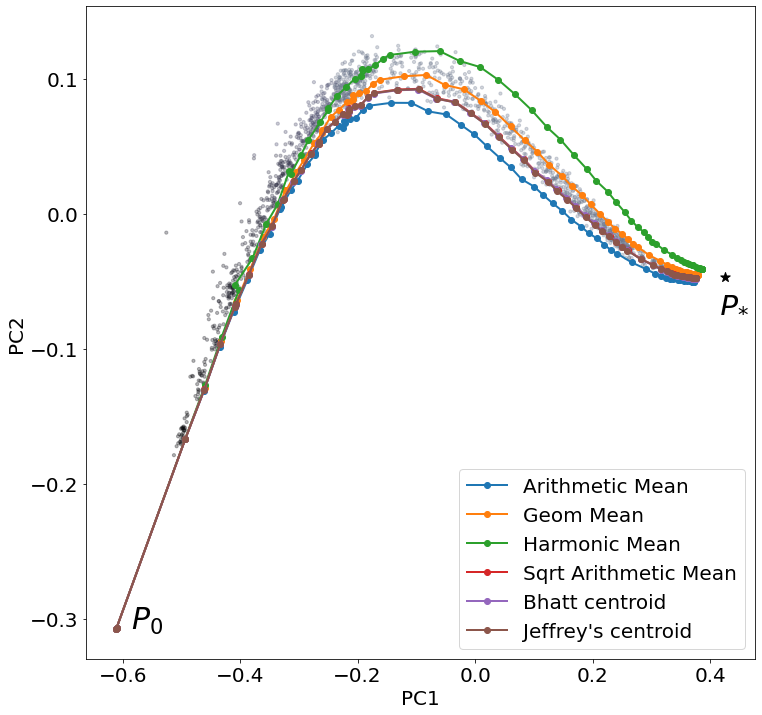

In [323]:
fig = plt.figure(figsize=(12,12))
plt.scatter(xp[:2010,0],xp[:2010,1],s=10,c=np.array(jialin_ind*30)/max(jialin_ind),cmap = 'bone', alpha = 0.3)
#label_m = [r'arithmetic mean',r'geom mean',r'harmonic mean',r'sqrt arithmetic mean',r' bhatt centroid ',r' Jeffrey centroid ']
for m in range(6):
    plt.plot(xp[2010+67*m:2010+67*(m+1),0],xp[2010+67*m:2010+67*(m+1),1],'o-',linewidth=2, label=label_m[m])
plt.text(xp[-1,0]-0.01,xp[-1,1]-0.025,r'$P_{*}$',fontsize=30)
plt.scatter(xp[-1,0],xp[-1,1],c='k',marker= '*',s=100)

plt.text(xp[0,0]+0.025,xp[0,1],r'$P_{0}$',fontsize=30)

plt.legend(fontsize=20)
plt.xlabel('PC1',fontsize=20)
plt.ylabel('PC2',fontsize=20)

#plt.tight_layout()
plt.savefig('training_err_averaging_traj.pdf', dpi=300)


In [7]:
truth_label = pickle.load(open(os.path.join(path_,'truth_label.p'),'rb'))

In [312]:
len(truth_label)

50000

In [45]:
embed_err = np.zeros((67,30))
for n in range(67):
    for k in range(30):
        embed_err[n,k] = p_list[k*67+n,np.arange(50000),truth_label].mean()
err_arithmetic = arithmetic_avg[:,np.arange(50000),truth_label].mean(1)
err_geometric = geometric_avg[:,np.arange(50000),truth_label].mean(1)
err_sqrt = arithmetic_sqrt_avg[:,np.arange(50000),truth_label].mean(1)
err_harmonic = harmonic_avg[:,np.arange(50000),truth_label].mean(1)

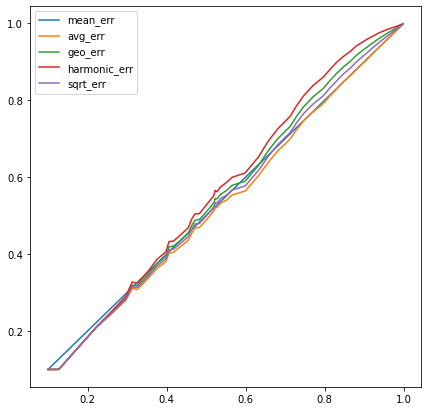

In [46]:
plt.figure(figsize=(7,7))

plt.plot(embed_err.mean(1),embed_err.mean(1),label='mean_err' )
plt.plot(embed_err.mean(1),err_arithmetic,label='avg_err' )
plt.plot(embed_err.mean(1),err_geometric ,label='geo_err' )
plt.plot(embed_err.mean(1),err_harmonic,label='harmonic_err' )
plt.plot(embed_err.mean(1),err_sqrt ,label='sqrt_err')
plt.legend()

# Validation Data

In [47]:
# distance matrix for plotting
p_list_test= pickle.load(open(os.path.join(save_path,'p_list_validation.p'), 'rb')) 

In [227]:
import tqdm

In [260]:
arithmetic_avg_test = np.zeros((67,10000,10))
geometric_avg_test= np.zeros((67,10000,10))
harmonic_avg_test= np.zeros((67,10000,10))
arithmetic_sqrt_avg_test= np.zeros((67,10000,10))
bhatt_centroid_test= np.zeros((67,10000,10))
skl_centroid_test= np.zeros((67,10000,10))

for n in tqdm.tqdm(range(67)):
    arithmetic_sqrt_avg_test[n,:,:]= ((np.sqrt(p_list_test[np.arange(30)*67+n,:,:])).mean(0))**2
    arithmetic_sqrt_avg_test[n,:,:]/=(arithmetic_sqrt_avg_test[n,:,:]).sum(1,keepdims=True)
    
    arithmetic_avg_test[n,:,:]= (p_list_test[np.arange(30)*67+n,:,:]).mean(0)
    arithmetic_avg_test[n,:,:]/=(arithmetic_avg_test[n,:,:]).sum(1,keepdims=True)
    
    geometric_avg_test[n,:,:]= np.exp(np.log(p_list_test[np.arange(30)*67+n,:,:]).mean(0))
    geometric_avg_test[n,:,:]/=(geometric_avg_test[n,:,:]).sum(1,keepdims=True)
    
    harmonic_avg_test[n,:,:]= ((p_list_test[np.arange(30)*67+n,:,:]**-1).mean(0))**-1
    harmonic_avg_test[n,:,:]/=harmonic_avg_test[n,:,:].sum(1,keepdims=True)

    bhatt_centroid_test[n,:,:]= Bhat_centroid(p_list_test[np.arange(30)*67+n,:,:])
    
    skl_centroid_test[n,:,:]=arithmetic_avg_test[n,:,:]/lambert(arithmetic_avg_test[n,:,:]*np.exp(1)/geometric_avg_test[n,:,:])
    skl_centroid_test[n,:,:]/= skl_centroid_test[n,:,:].sum(1,keepdims=True)


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [06:23<00:00,  5.73s/it]


In [333]:
naive_avg_centroids_test = {}
naive_avg_centroids_test['AM'] = arithmetic_avg_test
naive_avg_centroids_test['GM'] = geometric_avg_test
naive_avg_centroids_test['HM'] = harmonic_avg_test
naive_avg_centroids_test['sqrt-AM'] = arithmetic_sqrt_avg_test
naive_avg_centroids_test['bhatt'] = bhatt_centroid_test
naive_avg_centroids_test['skl'] = skl_centroid_test

pickle.dump(naive_avg_centroids_test,open(os.path.join(save_path,'naive_avg_centroids_test.p'), 'wb'))

In [49]:
tmp_test=np.concatenate((p_list_test.numpy(),arithmetic_avg_test,geometric_avg_test,harmonic_avg_test,arithmetic_sqrt_avg_test,bhatt_centroid_test,skl_centroid_test),axis=0)


In [151]:
Dbhatt_test= dbhat(th.concat((th.Tensor(tmp_test),th.Tensor(geo_end).unsqueeze(0)) ,axis=0),th.concat((th.Tensor(tmp_test),th.Tensor(geo_end).unsqueeze(0)) ,axis=0))

In [152]:
xp_test,e_test,v_test = projection(Dbhatt_test)

In [334]:

pickle.dump(xp_test,open(os.path.join(save_path,'inpca_coord_test.p'), 'wb'))

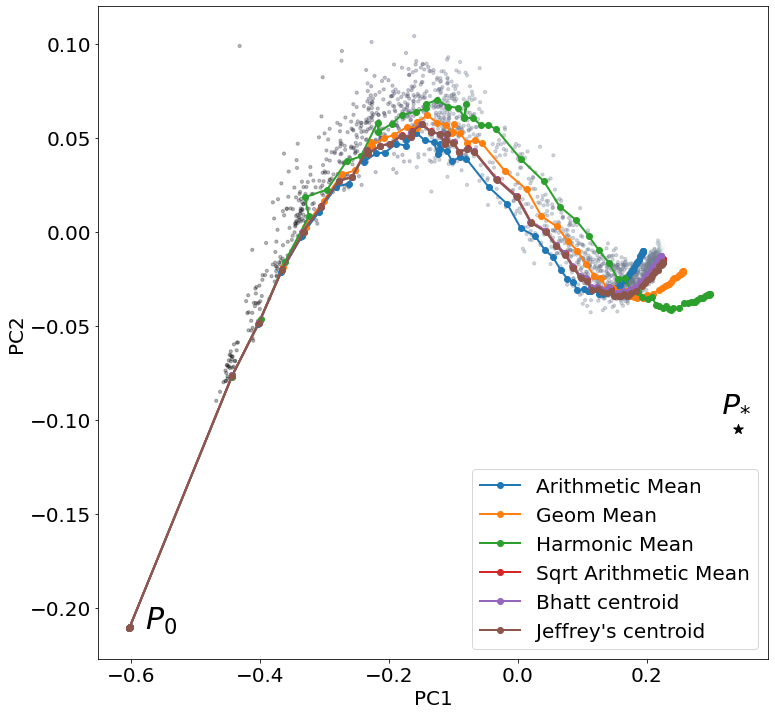

In [300]:
fig = plt.figure(figsize=(12,12))
plt.scatter(xp_test[:2010,0],xp_test[:2010,1],s=10,c=np.array(jialin_ind*30)/max(jialin_ind),cmap = 'bone', alpha = 0.3)
for m in range(6):
    plt.plot(xp_test[2010+67*m:2010+67*(m+1),0],xp_test[2010+67*m:2010+67*(m+1),1],'o-',linewidth=2, label=label_m[m])
plt.scatter(xp_test[-1,0],xp_test[-1,1],c='k',marker= '*',s=100)
plt.text(xp_test[-1,0]-0.025,xp_test[-1,1]+0.01,r'$P_{*}$',fontsize=30)
plt.text(xp_test[0,0]+0.025,xp_test[0,1],r'$P_{0}$',fontsize=30)

plt.axis('tight')
plt.legend(fontsize=20)
plt.xlabel('PC1',fontsize=20)
plt.ylabel('PC2',fontsize=20)
plt.savefig('validation_err_averaging_traj.pdf', dpi=300)


In [57]:
truth_label_test = pickle.load(open(os.path.join(path_,'truth_validation.p'),'rb'))

In [232]:

err_arithmetic_test = arithmetic_avg_test[:,np.arange(10000),truth_label_test].mean(1)
err_geometric_test = geometric_avg_test[:,np.arange(10000),truth_label_test].mean(1)
err_sqrt_test = arithmetic_sqrt_avg_test[:,np.arange(10000),truth_label_test].mean(1)
err_harmonic_test = harmonic_avg_test[:,np.arange(10000),truth_label_test].mean(1)

In [233]:
err_bhatt_centroid_test = bhatt_centroid_test[:,np.arange(10000),truth_label_test].mean(1)
err_skl_centroid_test = skl_centroid_test[:,np.arange(10000),truth_label_test].mean(1)

In [336]:
progress_err_ds = {}
progress_err_ds['progress_AM'] = project(th.sqrt(th.Tensor(arithmetic_avg_test)), th.sqrt(geo_start), th.sqrt(geo_end) ).mean(1)
progress_err_ds['validation_err_AM'] =err_arithmetic_test

progress_err_ds['progress_GM']= project(th.sqrt(th.Tensor(geometric_avg_test)), th.sqrt(geo_start), th.sqrt(geo_end) ).mean(1)
progress_err_ds['validation_err_GM'] = err_geometric_test

progress_err_ds['progress_HM']= project(th.sqrt(th.Tensor(harmonic_avg_test)), th.sqrt(geo_start), th.sqrt(geo_end) ).mean(1)
progress_err_ds['validation_err_HM'] =err_harmonic_test

progress_err_ds['progress_sqrtAM']= project(th.sqrt(th.Tensor(arithmetic_sqrt_avg_test)), th.sqrt(geo_start), th.sqrt(geo_end) ).mean(1)
progress_err_ds['validation_err_sqrtAM'] =err_sqrt_test

progress_err_ds['progress_Bhatt']= project(th.sqrt(th.Tensor(bhatt_centroid_test)), th.sqrt(geo_start), th.sqrt(geo_end) ).mean(1)
progress_err_ds['validation_err_Bhatt'] =err_bhatt_centroid_test

progress_err_ds['progress_sKL']= project(th.sqrt(th.Tensor(skl_centroid_test)), th.sqrt(geo_start), th.sqrt(geo_end) ).mean(1)
progress_err_ds['validation_err_sKL'] =err_skl_centroid_test


pickle.dump(progress_err_ds,open(os.path.join(save_path,'progress_err_ds.p'), 'wb'))

In [125]:
import matplotlib

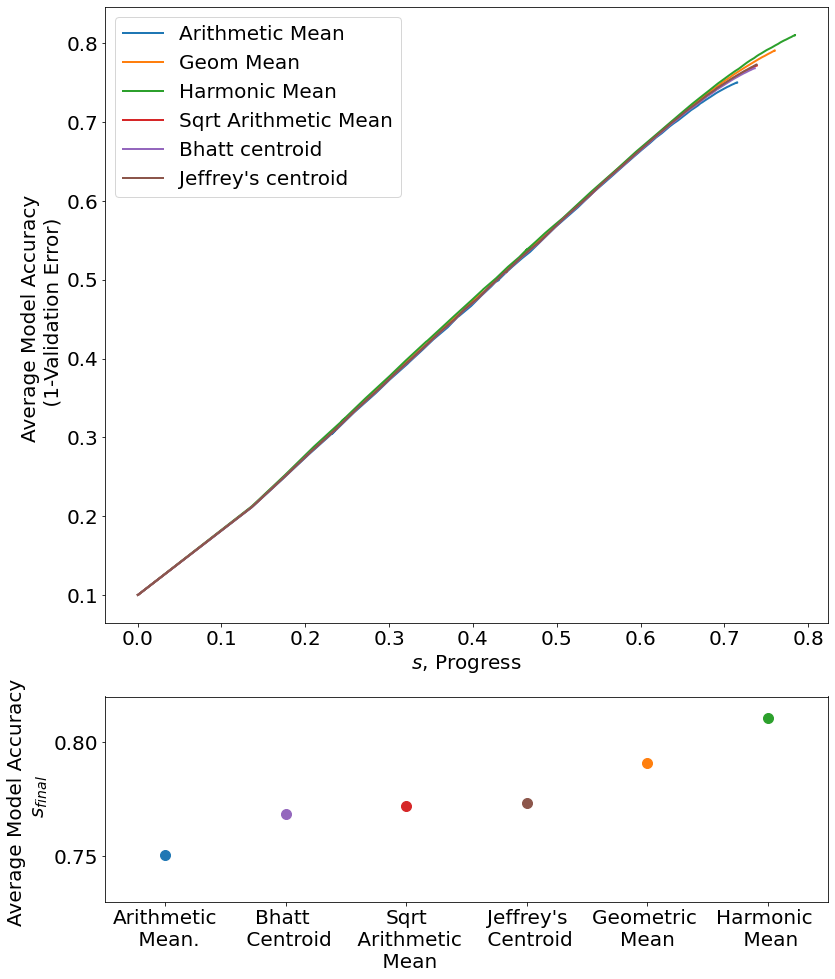

In [331]:

font = {
        'size'   : 20}

matplotlib.rc('font', **font)
label_m = [r'Arithmetic Mean',r'Geom Mean',r'Harmonic Mean',r'Sqrt Arithmetic Mean',r'Bhatt centroid ',"Jeffrey's centroid"]
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]},figsize=(12,14))

a0.plot(project(th.sqrt(th.Tensor(arithmetic_avg_test)), th.sqrt(geo_start), th.sqrt(geo_end) ).mean(1),err_arithmetic_test,label = label_m[0],linewidth=2)
a0.plot(project(th.sqrt(th.Tensor(geometric_avg_test)), th.sqrt(geo_start), th.sqrt(geo_end) ).mean(1),err_geometric_test,label = label_m[1],linewidth=2)

a0.plot(project(th.sqrt(th.Tensor(harmonic_avg_test)), th.sqrt(geo_start), th.sqrt(geo_end) ).mean(1),err_harmonic_test,label = label_m[2],linewidth=2)
a0.plot(project(th.sqrt(th.Tensor(arithmetic_sqrt_avg_test)), th.sqrt(geo_start), th.sqrt(geo_end) ).mean(1),err_sqrt_test,label = label_m[3],linewidth=2)
a0.plot(project(th.sqrt(th.Tensor(bhatt_centroid_test)), th.sqrt(geo_start), th.sqrt(geo_end) ).mean(1),err_bhatt_centroid_test,label = label_m[4],linewidth=2)
a0.plot(project(th.sqrt(th.Tensor(skl_centroid_test)), th.sqrt(geo_start), th.sqrt(geo_end) ).mean(1),err_skl_centroid_test,label = label_m[5],linewidth=2)
a0.legend()
a0.set_ylabel('Average Model Accuracy \n (1-Validation Error)')
a0.set_xlabel('$s$, Progress')
#plt.savefig('progress_vs_validation_err_averaging.pdf', dpi=300)

a1.scatter(0,err_arithmetic_test[-1],s=100)
a1.scatter(4,err_geometric_test[-1],s=100 )
a1.scatter(5,err_harmonic_test[-1],s=100)
a1.scatter(2,err_sqrt_test[-1] ,s=100)
a1.scatter(1,err_bhatt_centroid_test[-1],s=100)
a1.scatter(3,err_skl_centroid_test[-1] ,s=100)


a1.set_xticks([0,1,2,3,4,5],['Arithmetic\n Mean.','Bhatt \n Centroid','Sqrt\n Arithmetic\n Mean','Jeffrey\'s\n Centroid','Geometric \nMean','Harmonic \n Mean'])
a1.set_yticks([0.75,0.80])
a1.axis([-0.5,5.5,0.73,0.82])
a1.set_ylabel('Average Model Accuracy \n $s_{final}$')
#plt.xlabel('Type of Averaging')
f.tight_layout()
f.savefig('progress_vs_validation_err_averaging.pdf', dpi=300)


Text(0, 0.5, 'Average Model Accuracy \n (1-Validation Error)')

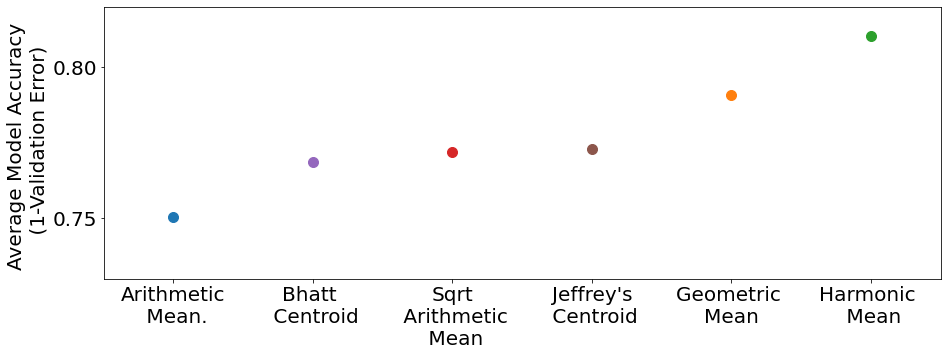

In [266]:
plt.figure(figsize=(15,5))
font = {
        'size'   : 20}

matplotlib.rc('font', **font)
plt.scatter(0,err_arithmetic_test[-1],s=100)
plt.scatter(4,err_geometric_test[-1],s=100 )
plt.scatter(5,err_harmonic_test[-1],s=100)
plt.scatter(2,err_sqrt_test[-1] ,s=100)
plt.scatter(1,err_bhatt_centroid_test[-1],s=100)
plt.scatter(3,err_skl_centroid_test[-1] ,s=100)


plt.xticks([0,1,2,3,4,5],['Arithmetic\n Mean.','Bhatt \n Centroid','Sqrt\n Arithmetic\n Mean','Jeffrey\'s\n Centroid','Geometric \nMean','Harmonic \n Mean'])
plt.yticks([0.75,0.80])
plt.axis([-0.5,5.5,0.73,0.82])
plt.ylabel('Average Model Accuracy \n (1-Validation Error)')
#plt.xlabel('Type of Averaging')


In [63]:
import numpy as np
from scipy import optimize
from tqdm import tqdm
import glob
from functools import partial

In [209]:

def project(r, p, q, debug=False, mode='mean'):
    # r, p, q shape (nmodels, nsamples, nclasses)
    # p, q: start and end points of the geodesic
    #nm, ns, nc = r.shape
    eps = 1e-8
    if debug:
        assert np.allclose([(r**2).sum(-1), (p**2).sum(-1), (q**2).sum(-1)], 1)
    cost = np.clip((p*q).sum(-1, keepdims=True), 0, 1)
    cost1 = np.clip((p*r).sum(-1, keepdims=True), 0, 1)
    cost2 = np.clip((q*r).sum(-1, keepdims=True), 0, 1)

    if mode == 'prod':
        ti = np.arccos(cost)
        mask = ti < eps
        d1 = np.arccos(cost1[mask]).sum()
        sinti = np.sin(ti)
        
        def d(t, n=1):
            maskn = mask[n, :]
            cost1_ = cost1[n:n+1, ~maskn]
            ti_ = ti[n:n+1, ~maskn]
            cost1_ = cost1[n:n+1, ~maskn]
            cost2_ = cost2[n:n+1, ~maskn]
            sinti_ = sinti[n:n+1, ~maskn]
            coss = cost1_*np.sin((1-t)*ti_) / sinti_ + \
                cost2_ * np.sin(t*ti_)/sinti_
            coss = np.clip(coss, 0, 1)
            t_ = np.arccos(coss)
            return d1 + t_.sum(1)

        lam = []
        for n in range(len(ti)):
            dn = partial(d, n=n)
            l = optimize.minimize_scalar(dn, bounds=(0, 1), method='bounded').x
            lam.append(float(l))
    elif mode == 'mean':
        tan = cost2/(cost1*np.sqrt(1-cost**2)) - cost / np.sqrt(1-cost**2)
        lam = (np.arctan(tan) * (tan > 0)) / np.arccos(cost)
        lam = np.clip(lam, 0, 1)

    return lam


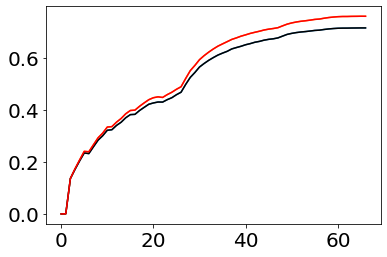

In [221]:
plt.plot(np.array(lam_arithmetic_mean).mean(1)) # from method = prod
plt.plot(np.array(lam_geometric_mean).mean(1))# from method = mean
plt.plot(project(th.sqrt(th.Tensor(arithmetic_avg_test)), th.sqrt(geo_start), th.sqrt(geo_end) ).mean(1),'k')# from method = prod
plt.plot(project(th.sqrt(th.Tensor(geometric_avg_test)), th.sqrt(geo_start), th.sqrt(geo_end) ).mean(1),'r')# from method = mean


seems to be the same and the mean method is faster

In [ ]:
lam_arithmetic_mean=[project(th.sqrt(th.Tensor(arithmetic_avg_test)[i,:]), th.sqrt(geo_start), th.sqrt(geo_end) ,mode='prod') for i in range(67)]
lam_geometric_mean=[project(th.sqrt(th.Tensor(geometric_avg_test)[i,:]), th.sqrt(geo_start), th.sqrt(geo_end) ,mode='prod') for i in range(67)]


In [ ]:
lam_sqrt_arithmetic_mean=[project(th.sqrt(th.Tensor(arithmetic_sqrt_avg_test)[i,:]), th.sqrt(geo_start), th.sqrt(geo_end) ,mode='prod') for i in range(67)]
lam_bhatt_centroid=[project(th.sqrt(th.Tensor(bhatt_centroid_test)[i,:]), th.sqrt(geo_start), th.sqrt(geo_end) ,mode='prod') for i in range(67)]
lam_skl_centroid=[project(th.sqrt(th.Tensor(skl_centroid_test)[i,:]), th.sqrt(geo_start), th.sqrt(geo_end) ,mode='prod') for i in range(67)]


In [66]:
geo_end = th.zeros(10000,10)
geo_end[np.arange(10000),truth_label_test]=1


In [67]:
geo_start = th.ones(10000,10)/10

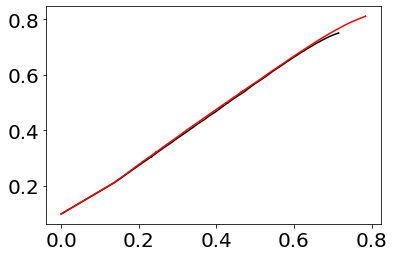

In [200]:
plt.plot(project(th.sqrt(th.Tensor(arithmetic_avg_test)), th.sqrt(geo_start), th.sqrt(geo_end) ).mean(1),err_arithmetic_test,'k')
plt.plot(project(th.sqrt(th.Tensor(harmonic_avg_test)), th.sqrt(geo_start), th.sqrt(geo_end) ).mean(1),err_harmonic_test,'r')


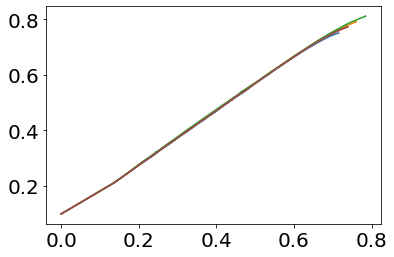

In [234]:
plt.plot(project(th.sqrt(th.Tensor(arithmetic_avg_test)), th.sqrt(geo_start), th.sqrt(geo_end) ).mean(1),err_arithmetic_test)
plt.plot(project(th.sqrt(th.Tensor(geometric_avg_test)), th.sqrt(geo_start), th.sqrt(geo_end) ).mean(1),err_geometric_test)

plt.plot(project(th.sqrt(th.Tensor(harmonic_avg_test)), th.sqrt(geo_start), th.sqrt(geo_end) ).mean(1),err_harmonic_test)
plt.plot(project(th.sqrt(th.Tensor(arithmetic_sqrt_avg_test)), th.sqrt(geo_start), th.sqrt(geo_end) ).mean(1),err_sqrt_test)
plt.plot(project(th.sqrt(th.Tensor(bhatt_centroid_test)), th.sqrt(geo_start), th.sqrt(geo_end) ).mean(1),err_bhatt_centroid_test)
plt.plot(project(th.sqrt(th.Tensor(skl_centroid_test)), th.sqrt(geo_start), th.sqrt(geo_end) ).mean(1),err_skl_centroid_test)


In [225]:
np.array(bhatt_centroid_test).shape

(67,)

In [64]:

def gamma(t, p, q):
    # p, q shape: nmodels, nsamples, nclasses
    cospq = np.clip((p*q).sum(-1), 0, 1)
    ti = np.arccos(cospq)
    mask = ti < 1e-8
    gamma = np.zeros_like(p)
    gamma[mask, :] = p[mask, :]
    p, q = p[~mask, :], q[~mask, :]
    ti = ti[~mask, None]
    gamma[~mask, :] = np.sin((1-t)*ti) / np.sin(ti) * \
        p + np.sin(t*ti) / np.sin(ti) * q
    return gamma

In [ ]:



def reparam(d, labels, num_ts=50, groups=['m', 'opt', 'seed'], key='yh'):
    new_d = []
    configs = d.groupby(groups).indices
    ts = np.linspace(0, 1, (num_ts+1))[1:]
    for (c, idx) in configs.items():
        di = d.iloc[idx]
        ind = {'yh': di.index.min(), 'yvh': di.index.min()}
        max_ind = di.index.max()
        for t in ts:
            data = {groups[i]: c[i] for i in range(len(c))}
            data['t'] = t
            for key in ['yh', 'yvh']:
                k = ind[key]
                while k < max_ind:
                    if di.iloc[k][f'lam_{key}'] > t:
                        break
                    k += 1
                if k == max_ind:
                    end_lam = 1
                else:
                    end_lam = di.iloc[k][f'lam_{key}']
                ind[key] = k
                start = di.iloc[max(0, k-1)]
                end = di.iloc[k]

                if abs(end_lam - start[f'lam_{key}']) < 1e-8:
                    import ipdb; ipdb.set_trace()
                lam_interp = (t - start[f'lam_{key}']) / (end_lam - start[f'lam_{key}'])
                lam_interp = np.clip(lam_interp, 0, 1)
                r = gamma(lam_interp, np.sqrt(start[key])[None, :], np.sqrt(end[key])[None, :])
                data[key] = (r ** 2).squeeze()
                errkey = 'err' if key == 'yh' else 'verr'
                fkey = 'favg' if key == 'yh' else 'vfavg'
                data[errkey] = (
                    np.argmax(data[key], axis=-1) != labels[key]).mean()
                data[fkey] = - \
                    np.log(data[key])[np.arange(
                        len(labels[key])), labels[key]].mean()
            new_d.append(data)
    return pd.DataFrame(new_d)
                ##################### old #########################
                # diff = 1
                # for k in ks:
                #     p = np.sqrt(di.loc[k][key])[None, :]
                #     q = np.sqrt(di.loc[k+1][key])[None, :]
                #     r = gamma(t, ps[key], qs[key])
                #     lam = project(r, p, q)[0]
                #     if abs(lam-0.5) < diff:
                #         diff = abs(lam-0.5)
                #         data[key] = (gamma(lam, p, q) ** 2).squeeze()
                #         errkey = 'err' if key == 'yh' else 'verr'
                #         fkey = 'favg' if key == 'yh' else 'vfavg'
                #         data[errkey] = (
                #             np.argmax(data[key], axis=-1) != labels[key]).mean()
                #         data[fkey] = - \
                #             np.log(data[key])[np.arange(
                #                 len(labels[key])), labels[key]].mean()
                #     print(c, t, k, lam, data[errkey], data[fkey])
                ##################### old #########################


def compute_lambda(reparam=False, force=False, separate=False, didx_fn='all', loc='results/models/all', save_loc='results/models/reindexed_new'):
    all_files = glob.glob(os.path.join(loc, '*}.p'))
    file_list = []
    for f in all_files:
        configs = json.loads(f[f.find('{'):f.find('}')+1])
        if configs.get('corner') == 'normal':
            file_list.append(f)

    data = get_data()
    labels = {}
    qs = {}
    ps = {}
    for key in ['train', 'val']:
        k = 'yh' if key == 'train' else 'yvh'
        y_ = np.array(data[key].targets, dtype=np.int32)
        y = np.zeros((y_.size, y_.max()+1))
        y[np.arange(y_.size), y_] = 1
        qs[k] = np.sqrt(np.expand_dims(y, axis=0))
        ps[k] = np.sqrt(np.ones_like(qs[k]) / 10)
        labels[k] = y_
    if not separate:
        qs = np.concatenate([qs['yh'], qs['yvh']], axis=1)
        ps = np.concatenate([ps['yh'], ps['yvh']], axis=1)
        labels = np.hstack([labels['yh'], labels['yvh']])

    didx_all = None
    cols = ['seed', 'aug', 'm', 'opt', 'bs', 'lr', 'wd', 't', 'err', 'verr', 'favg',
            'vfavg']
    if separate:
        cols = cols + ['lam_yh', 'lam_yvh']
    else:
        cols = cols + ['lam']
    for f in tqdm.tqdm(file_list):
        load_fn = os.path.join('results/models/loaded', os.path.basename(f))
        save_fn = os.path.join(save_loc, os.path.basename(f))
        if os.path.exists(save_fn) and not force:
            continue
        if not os.path.exists(load_fn):
            d = load_d(file_list=[f], avg_err=True, probs=False)
        else:
            try:
                d = th.load(load_fn)
            except:
                print(load_fn)
                continue
        if d is not None:
            yhs = {}
            for key in ['yh', 'yvh']:
                yhs[key] = np.stack(d[key].values)
                if not np.allclose(yhs[key].sum(-1), 1):
                    yhs[key] = np.exp(yhs[key])
                    probs = False
                else:
                    probs = True
                yhs[key] = np.sqrt(yhs[key])
                if separate:
                    qs_ = np.repeat(qs[key], yhs[key].shape[0], axis=0)
                    ps_ = np.repeat(ps[key], yhs[key].shape[0], axis=0)
                    d[f'lam_{key}'] = project(yhs, ps_, qs_)
            if not separate:
                # yhs = np.stack([yhs['yh'], yhs['yvh']])
                yhs = np.concatenate([yhs['yh'], yhs['yvh']], axis=1)
                qs_ = np.repeat(qs, yhs.shape[0], axis=0)
                ps_ = np.repeat(ps, yhs.shape[0], axis=0)
                d['lam'] = project(yhs, ps_, qs_)
            th.save(d, load_fn)
            didx_all = pd.concat([didx_all, d[cols]])
            th.save(
                didx_all, f'/home/ubuntu/ext_vol/inpca/results/models/loaded/didx_{didx_fn}.p')
        else:
            continue
        if reparam:
            for key in ['yh', 'yvh']:
                if not probs:
                    d[key] = d.apply(lambda r: np.exp(r[key]), axis=1)
            new_d = reparam(d, labels, num_ts=100,
                            groups=['seed', 'aug', 'm', 'opt', 'bs', 'lr', 'wd'])
            th.save(new_d, save_fn)
